In [2]:
from py_sc_fermi.defect_charge_state import DefectChargeState, FrozenDefectChargeState
from py_sc_fermi.defect_system import DefectSystem
from py_sc_fermi.defect_species import DefectSpecies
from py_sc_fermi.inputs import inputs_from_files, read_input_data
from scipy.constants import physical_constants
from scipy.spatial import ConvexHull
from itertools import product
from tqdm import tqdm
from pandas import DataFrame as df
from copy import deepcopy
from collections import defaultdict
import numpy as np
import sc_pyper_functions as scpf
import pandas as pd
import auto_functions as af
import matplotlib.pyplot as plt
import yaml
import re
import subprocess
import timeout_decorator


### import physical constants ###  

kb_e = physical_constants['Boltzmann constant in eV/K'][0]
j_to_ev = 1/physical_constants['electron volt-joule relationship'][0]
S_0 = 205 * j_to_ev / physical_constants['Avogadro constant'][0]
Cp = (7/2)*kb_e

### import defect data ###

with open('automator_config.yaml', 'r') as stream: # get defect information from .yaml config
    try:                                           
        defect_params = yaml.safe_load(stream)     # return as a dict called defect_params
    except yaml.YAMLError as exc:
        print(exc)
        
### import DFT data ###

defects = af.import_calculations_from_file('defects.yaml')         # read in raw vasp data as vasppy calculation objects.
elements = af.import_calculations_from_file('elements.yaml')       # and give them intuitive names
llzo = af.import_calculations_from_file('interest.yaml')           #
ex_grid = (pd.read_csv('ex_grid.dat', skiprows=10, sep='\s+'))     # read in chemical potential grids as outputted by cplap 
grid = (pd.read_csv('grid.dat', skiprows=10, sep='\s+'))           # with both a larger grid and a smaller grid

### FORTRAN SC-Fermi wrappers ###

class chg_car_SCFermi:
    """
    SCFermi class containing all information needed to carry out an SC-Fermi calculationm including defects, number of eletrons, band gap magnitude, temperature, and whether the DFT calculation was spin polarised 
    currently only allows consideration of one 'dopant'
    """

    def __init__( self, defects, nelect, e_gap, temperature, dopants=None, fixed_defects=None, spin_polarised=False):
        self.defects = defects
        self.fixed_defects = fixed_defects
        self.nelect = nelect
        self.e_gap = e_gap
        self.temperature = temperature
        self.spin_polarised = spin_polarised
        self.dopants = dopants

    @property
    def n_defects( self ):
        return len( self.defects )
    
    @property
    def n_fixed_defects( self ):
        return len( self.fixed_defects )

    def output( self ):
            with open('input-fermi-frozen.dat', 'w') as f:
                if self.spin_polarised:
                    f.write( '2' + '\n')
                else:
                    f.write( '1' + '\n' )
                f.write( str(self.nelect) + '\n' )
                f.write( str(self.e_gap) + '\n')
                f.write( str(self.temperature) + '\n')
                f.write( str(self.n_defects) + '\n' )
                for d in self.defects:
                    f.write( '{} {} {}'.format( d.label, d.n_charge_states, d.n_sites ) + '\n')
                    for c in d.charge_states:
                        f.write( '{} {} {}'.format( c.charge, c.formation_energy, c.degeneracy ) + '\n')
                
                if self.fixed_defects is not None:
                    f.write( str(self.n_fixed_defects) + '\n' )
                    for k,v in self.fixed_defects.items():
                        f.write( '{} {}'.format( k, v ) + '\n')
                else:
                    f.write('0' + '\n')
                if self.dopants is not None:
                    f.write( '1' + '\n')
                    for k,v in self.dopants.items():
                        f.write( 'Dopant ' + '{} {}'.format( k, v ) + '\n')
                else:
                    f.write('0')
            f.close()
            
    
def run_some_chg_car_fermi(defects, nelect, e_gap, temperature, dopants=None, fixed_defects=None, spin_polarised=False):
    """
    a function to run a frozen SCFermi calculation, and retun the concentrations of all the relevent defects. 
    args:
        defects (list): a list of defects to be considered as part of this calculation
        T (float): the temperature (in Kelvin) the concentrations are to be calculated at
        e_gap (float): magnitude of bandgap
        spin_polarised (bool): whether the DFT data is spin polarised
        dopant_chg (int): charge on the frozen defect
        dopant_conc (int): concentration of the frozen defect in n/cm-3
    returns:
        flat (dict): a dictionary specifiying defect concentrations.
        
        Note: function currently assumes executable frozen sc-fermi in directory.
    """
    out = []
    scf = chg_car_SCFermi(defects, nelect, e_gap, temperature, dopants, fixed_defects, spin_polarised=False)
    scf.output()
    with open("out.txt", 'w') as f:
        sp = subprocess.run(["./frozen-sc-fermi"],stdout=f)
        text_file = open(("out.txt") , "r")
        lines =  text_file.readlines()
        for i in defects:
                for line in lines:
                    if re.search(str(i.label)+' '+r'.*?Charge',line) is not None:
                        for h in range(i.n_charge_states):
                            joop = lines[lines.index(line)+(h+1)]
                            coop = joop.split()
                            x = coop[1]
                            y = float(coop[-2])
                            a_dict = {(i.label)+'_'+str(x) : y}
                            out.append(a_dict)
                            flat = {k: v for d in out for k, v in d.items()}
        for line in lines:
            if re.search('\(electrons\)', line) is not None:
                flat.update({'c_e' : float(line.split()[3])})
            if re.search('\(holes\)', line) is not None:
                flat.update({'c_h' : float(line.split()[3])})
            if re.search('\(eV\)', line) is not None:
                flat.update({'Fermi_level' : float(line.split()[4])})
            if re.search('Dopant\ \ \ \ \ \ \ \ \ :', line) is not None:
                flat.update({'Dopant' : float(line.split()[2])})
        return flat
    
class SYFermi:
    """
    SCFermi class containing all information needed to carry out an SC-Fermi calculationm including defects, number of eletrons, band gap magnitude, temperature, and whether the DFT calculation was spin polarised 
    currently only allows consideration of one 'dopant'
    """

    def __init__( self, defects, nelect, e_gap, temperature, fixed_charge_states=None, fixed_defects=None, spin_polarised=False):
        self.defects = defects
        self.fixed_defects = fixed_defects
        self.fixed_charge_states = fixed_charge_states
        self.nelect = nelect
        self.e_gap = e_gap
        self.temperature = temperature
        self.spin_polarised = spin_polarised

    @property
    def n_defects( self ):
        return len( self.defects )
    
    @property
    def n_fixed_defects( self ):
        return len( self.fixed_defects )
    
    @property
    def n_fixed_charge_states( self ):
        return len( self.fixed_charge_states )

    def output( self ):
            with open('input-fermi-frozen.dat', 'w') as f:
                if self.spin_polarised:
                    f.write( '2' + '\n')
                else:
                    f.write( '1' + '\n' )
                f.write( str(self.nelect) + '\n' )
                f.write( str(self.e_gap) + '\n')
                f.write( str(self.temperature) + '\n')
                f.write( str(self.n_defects) + '\n' )
                for d in self.defects:
                    f.write( '{} {} {}'.format( d.label, d.n_charge_states, d.n_sites ) + '\n')
                    for c in d.charge_states:
                        f.write( '{} {} {}'.format( c.charge, c.formation_energy, c.degeneracy ) + '\n')
                
                if self.fixed_defects is not None:
                    f.write( str(self.n_fixed_defects) + '\n' )
                    for k,v in self.fixed_defects.items():
                        f.write( '{} {}'.format( k, v ) + '\n')
                else:
                    f.write('0' + '\n')
                    
                if self.fixed_charge_states is not None:
                    f.write( str(self.n_fixed_charge_states) + '\n')
                    for i in self.fixed_charge_states:
                        i = i[0].split(' ')
                        f.write( '{} {} {}'.format( i[0], i[1], i[2] ) + '\n')
                else:
                    f.write('0')
            f.close()
            
    
def run_some_chg_car_fermi(defects, nelect, e_gap, temperature, dopants=None, fixed_defects=None, spin_polarised=False):
    """
    a function to run a frozen SCFermi calculation, and retun the concentrations of all the relevent defects. 
    args:
        defects (list): a list of defects to be considered as part of this calculation
        T (float): the temperature (in Kelvin) the concentrations are to be calculated at
        e_gap (float): magnitude of bandgap
        spin_polarised (bool): whether the DFT data is spin polarised
        dopant_chg (int): charge on the frozen defect
        dopant_conc (int): concentration of the frozen defect in n/cm-3
    returns:
        flat (dict): a dictionary specifiying defect concentrations.
        
        Note: function currently assumes executable frozen sc-fermi in directory.
    """
    out = []
    scf = chg_car_SCFermi(defects, nelect, e_gap, temperature, dopants, fixed_defects, spin_polarised=False)
    scf.output()
    with open("out.txt", 'w') as f:
        sp = subprocess.run(["./frozen-sc-fermi"],stdout=f)
        text_file = open(("out.txt") , "r")
        lines =  text_file.readlines()
        for i in defects:
                for line in lines:
                    if re.search(str(i.label)+' '+r'.*?Charge',line) is not None:
                        for h in range(i.n_charge_states):
                            joop = lines[lines.index(line)+(h+1)]
                            coop = joop.split()
                            x = coop[1]
                            y = float(coop[-2])
                            a_dict = {(i.label)+'_'+str(x) : y}
                            out.append(a_dict)
                            flat = {k: v for d in out for k, v in d.items()}
        for line in lines:
            if re.search('\(electrons\)', line) is not None:
                flat.update({'c_e' : float(line.split()[3])})
            if re.search('\(holes\)', line) is not None:
                flat.update({'c_h' : float(line.split()[3])})
            if re.search('\(eV\)', line) is not None:
                flat.update({'Fermi_level' : float(line.split()[4])})
            if re.search('Dopant\ \ \ \ \ \ \ \ \ :', line) is not None:
                flat.update({'Dopant' : float(line.split()[2])})
        return flat
    
    
def run_some_SY_fermi(defects, nelect, e_gap, temperature, fixed_charge_states=None, fixed_defects=None, spin_polarised=False):
    """
    a function to run a frozen SCFermi calculation, and retun the concentrations of all the relevent defects. 
    args:
        defects (list): a list of defects to be considered as part of this calculation
        T (float): the temperature (in Kelvin) the concentrations are to be calculated at
        e_gap (float): magnitude of bandgap
        spin_polarised (bool): whether the DFT data is spin polarised
        dopant_chg (int): charge on the frozen defect
        dopant_conc (int): concentration of the frozen defect in n/cm-3
    returns:
        flat (dict): a dictionary specifiying defect concentrations.
        
        Note: function currently assumes executable frozen sc-fermi in directory.
    """
    out = []
    scf = SYFermi(defects, nelect, e_gap, temperature,  fixed_charge_states, fixed_defects, spin_polarised=True)
    scf.output()
    with open("out.txt", 'w') as f:
        sp = subprocess.run(["./frozen-sc-fermi"],stdout=f)
        text_file = open(("out.txt") , "r")
        lines =  text_file.readlines()
        for i in defects:
                for line in lines:
                    if re.search(str(i.label)+' '+r'.*?Charge',line) is not None:
                        for h in range(i.n_charge_states):
                            joop = lines[lines.index(line)+(h+1)]
                            coop = joop.split()
                            x = coop[1]
                            y = float(coop[-2])
                            a_dict = {(i.label)+'_'+str(x) : y}
                            out.append(a_dict)
                            flat = {k: v for d in out for k, v in d.items()}
        for line in lines:
            if re.search('\(electrons\)', line) is not None:
                flat.update({'c_e' : float(line.split()[3])})
            if re.search('\(holes\)', line) is not None:
                flat.update({'c_h' : float(line.split()[3])})
            if re.search('\(eV\)', line) is not None:
                flat.update({'Fermi_level' : float(line.split()[4])})
            if re.search('Dopant\ \ \ \ \ \ \ \ \ :', line) is not None:
                flat.update({'Dopant' : float(line.split()[2])})
        return flat

@timeout_decorator.timeout(20)
def doStuff(xj):
    #for xj in list(conditions):
        res = []
        sy = []
        fabs = []
        freeze = []
        jeez = []
        itscrazybutitmightjustwork = []
        for i in temps: 
                results = scpf.run_some_fermi(scpf.compile_defects(grid.iloc[xj].to_dict()),nelect=544, e_gap=5.9034, T=1500, spin_polarised=True)
                re2 = scpf.run_some_fermi(scpf.compile_defects(grid.iloc[xj].to_dict()),nelect=544, e_gap=5.9034, T=i, spin_polarised=True)
                #print(results)
                for_frozen = {k : v for k,v in results.items() if k == 'v_Li_-1.0' or k == 'v_Li_0.0' or k == 'Li_i_1.0' or k == 'Li_i_0.0'}
                res.append(re2['c_e'])
                formatt = [(str(k.split('_')[:-1]), v) for k,v in for_frozen.items()]
                z = defaultdict(list) 
                for k, v in formatt:
                     z[k].append(v)
                gg = {k:sum(v) for k,v in z.items()}
                regex = re.compile('[^a-zA-Z,]')
                x = {regex.sub('', k):v for k,v in gg.items()}
                regex = re.compile('[^a-zA-Z]')
                y = {regex.sub('_', k):v for k,v in x.items()}
                defex = []
                del results['Fermi_level']
                del results['c_h']
                del results['c_e']
                del results['v_Li_-1.0']
                del results['v_Li_0.0']
                del results['Li_i_1.0']
                del results['Li_i_0.0']
                for k,v in results.items():
                    if k is not 'Fermi_level' or k is not 'c_e' or k is not 'c_h':
                        d = [k.split('_')[0]+'_'+k.split('_')[1] + ' ' + k.split('_')[-1] + ' ' + str(v)]
                        defex.append(d)
                please = run_some_chg_car_fermi(scpf.compile_defects(grid.iloc[xj].to_dict()),nelect=544, e_gap=5.9034, temperature=i, spin_polarised=True)
                frz = run_some_SY_fermi(scpf.compile_defects(grid.iloc[xj].to_dict()),nelect=544, e_gap=5.9034, temperature=i, spin_polarised=True, fixed_defects=y, fixed_charge_states=defex)
                freeze.append(frz['c_e'])
                sleaze = run_some_SY_fermi(scpf.compile_defects(grid.iloc[xj].to_dict()),nelect=544, e_gap=5.9034, temperature=i, spin_polarised=True, fixed_defects=None, fixed_charge_states=defex)
                fabs.append(sleaze['c_e'])
                itscrazybutitmightjustwork.append(please['c_e'])       
        ax.plot(temps,np.log10(freeze),label='ICL',marker='o')
        ax.plot(temps,np.log10(res),label='No Tricks',marker='o')
        ax.legend()
        #plt.show()
    
### py_sc_fermi convencience function ###

def make_all_defects(config_dict,chem_pots):
    """
    Take defect data and return py_sc_fermi friendly defect objects.
    """
    defs = []
    for k,v in config_dict['defects'].items():
        label = [i for i in config_dict['defects'][k][1:]]
        to_calcs = [defects[i] for i in label]
        out = af.make_defect(to_calcs, elements, llzo['LLZO'], delta_mu=chem_pots, corr=config_dict['iccs'], sites=1)
        out._nsites = config_dict['defects'][out.name][0]
        defs.append(out)
    return defs



def dependance(P,T):
    """
    This function gives dependance of mu_O(T,P)
    args: P = pressure (float)
          T = temperature (float)
    returning:
          mu_O(T,P) (float)
    assuming oxygen is an ideal gas
    """

    chem_pot = 0.5 * ( (Cp * (T - 298))
                      - T * ( (S_0 + (Cp * np.log(T/298)) + (kb_e * np.log((0.21/P)) ) ) ))
    return chem_pot   

### set up reference sc-fermi calculations ###

unitcell_filename = 'unitcell.dat'            # read structure
totdos_filename = 'totdos.dat'                # read totdos.dat
input_fermi_filename = 'input_fermi_cont.dat' # read default calculation params
inputs = inputs_from_files(unitcell_filename=unitcell_filename,                    # read sc-fermi data
                                   input_fermi_filename=input_fermi_filename,      # read input basics 
                                   totdos_filename=totdos_filename)                # read dos data  

chemical_potentials=[]
temperature = np.arange(1300, 1550, 50)  # specify range of synthesis temperatures
pressure = np.logspace(-1, -10, num=20)  # specify range of synthesis pressures
in_conds = product(pressure,temperature) # convert these into an array
for condition_set in tqdm(in_conds):     # loop over all permutations of in conditions
    mu_o = dependance(condition_set[0], condition_set[1])    # calculate oxygen chemical potential based of temperature and pressure 
    for point in range(grid.shape[0]):                       # for all points in the CPLAP grid
        if round(mu_o,1) == round(grid['mu_O'][point],1):    # find the grid points that match chemical potentials of in conditions
            chemical_potentials.append(point)                # add these to condtions
conditions = set(chemical_potentials)                        # find the set of these

charge_states = {'v_O':[0,1,2],
 'O_i':[0,-1],
 'v_La':[-3],
 'v_Zr':[-4],
 'Zr_i':[0,1,2,3,4],
 'Zr_Li_tet':[0,1,2,3],
 'Zr_Li':[0,1,2,3],
 'Zr_La':[0,1],
 'La_Zr':[0,-1],
 'La_Li':[0,1,2],
 'Li_La':[0,-1,-2],
 'Li_Zr':[0,-1,-2,-3]}

Volume of cell: 1056.622886347127 A^3


FileNotFoundError: [Errno 2] No such file or directory: 'input_fermi_cont.dat'

Volume of cell: 1056.622886347127 A^3
Found spin polarised system...
Number of electrons in system: 544
Energy gap of system: 5.904 eV
Temperature: 1500.0 K
Number of defect species: 14
Reading spin-polarised DOS


AttributeError: 'DefectSystem' object has no attribute 'spin_pol'

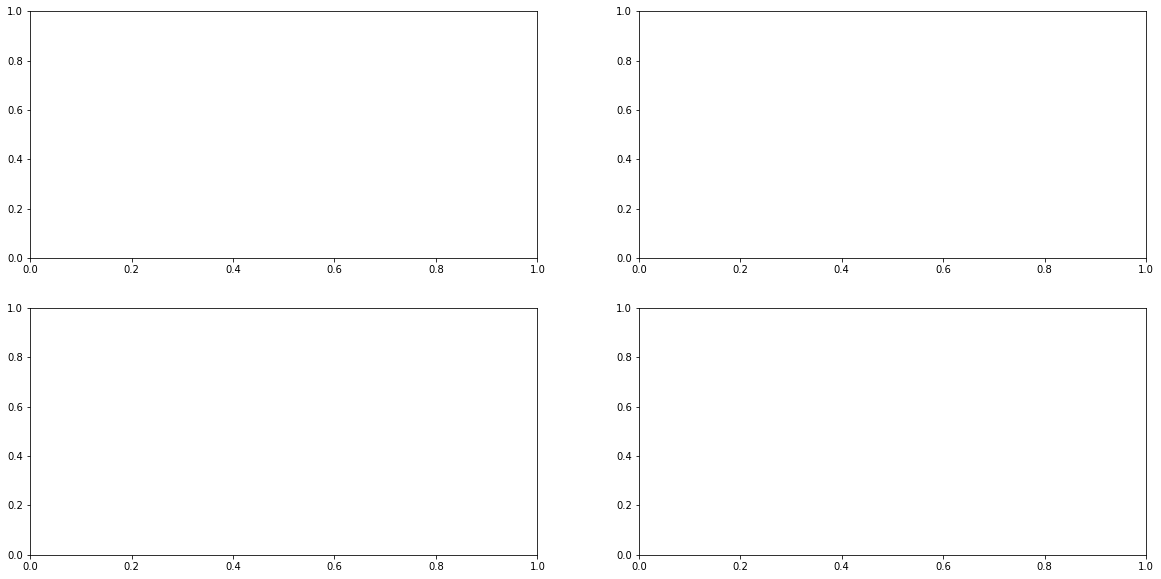

In [12]:
unitcell_filename = 'unitcell.dat' # Read structure
totdos_filename = 'totdos.dat'     # read totdos.dat
input_fermi_filename = 'input_fermi_cont.dat' # read default calculation params

counter = 0
fig, axs = plt.subplots(2,2, figsize=(20,10))
axs=axs.flatten()
for index,grid_to_test in enumerate([39,40]):
    
    if counter > 0:
        counter += 1
    ax = axs[counter]
    compilied_defects = make_all_defects(defect_params,grid.iloc[grid_to_test])
    reference_defects = deepcopy(compilied_defects)
    inputs = inputs_from_files(unitcell_filename=unitcell_filename, 
                                   input_fermi_filename=input_fermi_filename, 
                                   totdos_filename=totdos_filename, frozen=False)
    defect_system_reference = DefectSystem(defect_species=reference_defects,volume=inputs['volume'],dos=inputs['dos'],temperature=1500)#, spin_pol=2
    a = defect_system_reference.to_dict()
    b = defect_system_reference.to_dict(decomposed=True)

    temps = np.arange(200,1550,50)
    kb_e = physical_constants['Boltzmann constant in eV/K'][0]

    fixed_defects = []
    for k,v in charge_states.items():
        fixed_defects.append(DefectSpecies(k,1,[FrozenDefectChargeState(i,b[k][str(i)]/1e24*defect_system_reference.volume) for i in v]))
    fixed_defects.append(DefectSpecies('v_Li',3,[reference_defects[1].charge_states[0],reference_defects[1].charge_states[-1]]))
    fixed_defects.append(DefectSpecies('Li_i',1,[reference_defects[2].charge_states[0],reference_defects[2].charge_states[1]]))
    fixed_defects[-2].fix_concentration(a['v_Li']/1e24*defect_system_reference.volume)
    fixed_defects[-1].fix_concentration(a['Li_i']/1e24*defect_system_reference.volume)

    imperial = []
    for i in temps:
        defect_system = DefectSystem(defect_species=fixed_defects,volume=inputs['volume'],dos=inputs['dos'],temperature=i)#, spin_pol=2
        imperial.append(np.log10(defect_system.to_dict()['n0']))
    ax.plot(temps,imperial,'-o', label='python ICL')

    fixed_defects = []
    for k,v in charge_states.items():
        fixed_defects.append(DefectSpecies(k,1,[FrozenDefectChargeState(i,b[k][str(i)]/1e24*defect_system_reference.volume) for i in v]))
    fixed_defects.append(DefectSpecies('v_Li',3,[reference_defects[1].charge_states[0],reference_defects[1].charge_states[-1]]))
    fixed_defects.append(DefectSpecies('Li_i',1,[reference_defects[2].charge_states[0],reference_defects[2].charge_states[1]]))

    na = []
    for i in temps:
        defect_system = DefectSystem(defect_species=fixed_defects,volume=inputs['volume'],dos=inputs['dos'],temperature=i)#, spin_pol=2
        na.append(np.log10(defect_system.to_dict()['n0']))
    ax.plot(temps,na,'-o',label='python No Tricks')

    fixed_defects = []
    for k,v in charge_states.items():
        fixed_defects.append(DefectSpecies(k,1,[FrozenDefectChargeState(i,b[k][str(i)]/1e24*defect_system_reference.volume) for i in v]))
    fixed_defects.append(DefectSpecies('v_Li',3,[reference_defects[1].charge_states[0],reference_defects[1].charge_states[-1]]))
    fixed_defects.append(DefectSpecies('Li_i',1,[reference_defects[2].charge_states[0],reference_defects[2].charge_states[1]]))

#     bath = []
#     for i in temps:
#         defect_system = DefectSystem(defect_species=fixed_defects,volume=inputs['volume'],dos=inputs['dos'],temperature=i)#, spin_pol=2
#         fermi = defect_system.get_constrained_sc_fermi({'v_Li': +1, 'Li_i': -1}, (a['v_Li'] - a['Li_i']))
#         e,h = defect_system.dos.carrier_concentrations(fermi, kb_e*i)
#         bath.append(np.log10(h*1e24/defect_system.volume))
#     ax.plot(temps,bath,'-o',label='python Bath')
#     ax.set_xlabel('T / K')
#     ax.set_ylabel('[e] / cm$^-3$')
#     ax.set_title('py_sc_fermi')
#     ax.legend()
    
    try:
        doStuff(grid_to_test)
    except:
        print('TD')
        counter+=1
        continue
    ax.set_title('FORTRAN SC-FERMI')
    ax.set_xlabel('T / K')
    ax.set_ylabel('[e] / cm$^-3$')
    
    counter +=1
    ax = axs[counter]
    O = list(grid.iloc[list(conditions)]['mu_O'])
    Li = list(grid.iloc[list(conditions)]['mu_Li'])
    points =[[i,j] for i,j in zip(O,Li)]
    hull = ConvexHull(points)
    vertices_x = [points[i][0] for i in hull.vertices]
    vertices_y = [points[i][1] for i in hull.vertices]
    ax.plot(vertices_x+[vertices_x[0]],vertices_y+[vertices_y[0]])
    ax.scatter(grid.iloc[grid_to_test]['mu_O'],grid.iloc[grid_to_test]['mu_Li'],color='C1')
    ax.set_xlabel('$\mu_\mathrm{O}$ / eV')
    ax.set_ylabel('$\mu_\mathrm{Li}$ / eV')
    ax.set_title('chem pots')
    

    
plt.tight_layout()
plt.show()
#plt.savefig('please.pdf')

In [19]:
compilied_defects = make_all_defects(defect_params,grid.iloc[40])
reference_defects = deepcopy(compilied_defects)
inputs = inputs_from_files(unitcell_filename=unitcell_filename, 
                                input_fermi_filename='high_t_nothing_fixed.dat', 
                                totdos_filename=totdos_filename, frozen=False)
defect_system_reference = DefectSystem(defect_species=compilied_defects,volume=inputs['volume'],dos=inputs['dos'],temperature=500)#, spin_pol=2
defect_system_reference.report()

Volume of cell: 1056.622886347127 A^3
Found spin polarised system...
Number of electrons in system: 544
Energy gap of system: 5.904 eV
Temperature: 1500.0 K
Number of defect species: 14
Reading spin-polarised DOS
SC Fermi level :      3.12593351705938  (eV)

Concentrations:
n (electrons)  : 5.529780157673606e-08 cm^-3
p (holes)      : 7.939617197839504e-11 cm^-3
v_O            : 0.009466097927346736 cm^-3
v_Li           : 1.1840234568974868e+16 cm^-3
Li_i           : 1.1840234568861858e+16 cm^-3
O_i            : 3.564700657261788e-22 cm^-3
v_La           : 1.3152607736924047e-08 cm^-3
v_Zr           : 1.3496861406397588e-27 cm^-3
Zr_i           : 9.898450015237556e-15 cm^-3
Zr_Li_tet      : 1.4397722414040288e-11 cm^-3
Zr_Li          : 27930.445685600494 cm^-3
Zr_La          : 109522.4679455258 cm^-3
La_Zr          : 14.909931188530404 cm^-3
Li_La          : 32197.643290134452 cm^-3
Li_Zr          : 518.2032337354948 cm^-3
La_Li          : 3.2570002449193433e-07 cm^-3

Breakdown of con

/mnt/c/Users/Alex/Materials_work/new_fermi/py-sc-fermi/py_sc_fermi/dos.py:86: RuntimeWarning: overflow encountered in exp
  return dos / (1.0 + np.exp((e_fermi - edos)/kT))
/mnt/c/Users/Alex/Materials_work/new_fermi/py-sc-fermi/py_sc_fermi/dos.py:89: RuntimeWarning: overflow encountered in exp
  return dos / (1.0 + np.exp((edos - e_fermi)/kT))
/mnt/c/Users/Alex/Materials_work/new_fermi/py-sc-fermi/py_sc_fermi/defect_charge_state.py:79: RuntimeWarning: overflow encountered in exp
  return self.degeneracy * np.exp(expfac)
